# 課題①　あるクラウドファンディングが成功するかを事前に予測する

#### 必要なライブラリのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#### データの読み込み、確認


In [2]:
df_ks =  pd.read_csv('ks-projects-201801.csv') 

display(df_ks.head())
df_ks.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [4]:
#欠損値の数
df_ks.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
df_ks.nunique()

ID                  378661
name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

### 目的変数 stateについて調べる

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

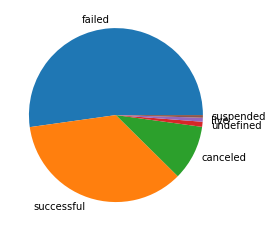

In [6]:
state_count = df_ks["state"].value_counts()
plt.pie(state_count, labels=state_count.index)
state_count

#### 今回は成功か失敗かを事前に予測するモデルの構築を目的とする。successful, failedのデータのみを扱うこととする。

In [7]:
#成功だけを抽出したDFと失敗だけを抽出したDF
df_ks_success = df_ks[df_ks['state']=='successful']
df_ks_failed =  df_ks[df_ks['state']=='failed']
#両方を結合
df_ks_2 = pd.concat([df_ks_success,df_ks_failed])
#stateの要素の個数を数えてみる。
df_ks_2['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [8]:
df_ks_2.loc[df_ks_2['state'] == "successful", 'state'] = 1
df_ks_2.loc[df_ks_2['state'] == "failed", 'state'] = 0

#### pledged, usd pledged, usd_pledged_realは実際の結果として集まった資金を表す値なので、事前予測においては使用不可と判断した。

In [9]:
df_ks_2 = df_ks_2.drop(["ID", "pledged", "usd pledged", "usd_pledged_real"], axis=1)

### 量的変数の可視化

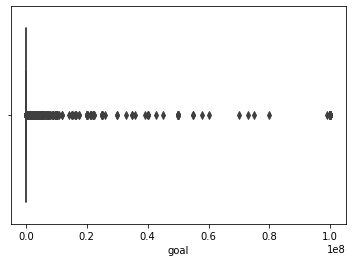

In [10]:
sns.boxplot(df_ks_2["goal"])

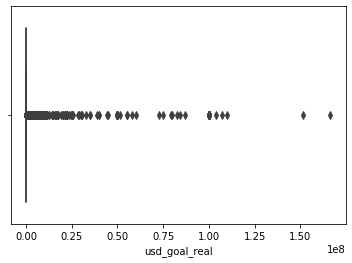

In [11]:
sns.boxplot(df_ks_2["usd_goal_real"])

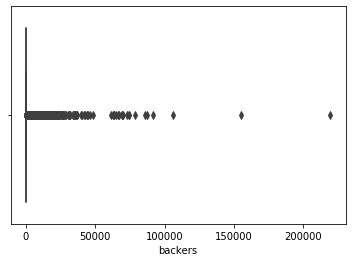

In [12]:
sns.boxplot(df_ks_2["backers"])

#### 両データとも値が0付近にかなり集中している。
#### 以下では標準化を行っておく。

In [13]:
# 標準化の例
# 標準化とは、平均を引いて、標準偏差で割る操作
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ks_2["usd_goal_real_std"]=stdsc.fit_transform(df_ks_2[["usd_goal_real"]].values)
df_ks_2["backers_std"]=stdsc.fit_transform(df_ks_2[["backers"]].values)


### 期間について　
#### launchからdeadlineまでの時間の長さを変数deltaとして新たに追加した。またlaunchされた年を変数yearとして追加した。　

In [14]:
df_ks_2["launched"]= pd.to_datetime(df_ks_2["launched"])
df_ks_2["deadline"]= pd.to_datetime(df_ks_2["deadline"])
df_ks_2["delta"]=(df_ks_2["deadline"]-df_ks_2["launched"]).dt.seconds


In [15]:
df_ks_2["delta"].describe()

count    331675.000000
mean      37538.779010
std       27822.608677
min           0.000000
25%       13872.000000
50%       27603.000000
75%       65898.500000
max       86399.000000
Name: delta, dtype: float64

In [16]:
df_ks_2["year"]=df_ks_2["launched"].dt.year

In [17]:
print(df_ks_2.dtypes)
df_ks_2.head()

name                         object
category                     object
main_category                object
currency                     object
deadline             datetime64[ns]
goal                        float64
launched             datetime64[ns]
state                         int64
backers                       int64
country                      object
usd_goal_real               float64
usd_goal_real_std           float64
backers_std                 float64
delta                         int64
year                          int64
dtype: object


,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,usd_goal_real_std,backers_std,delta,year
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,1,224,US,50000.00,0.007656,0.111472,37293,2016
6,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1,16,US,1000.00,-0.036531,-0.103976,19756,2014
11,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,1,100,US,12500.00,-0.026160,-0.016968,62222,2013
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,1,761,GB,6469.73,-0.031598,0.667704,15342,2017
18,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,1,7,US,250.00,-0.037207,-0.113299,35308,2012


year  state
2009  0          600
      1          579
2010  0         4984
      1         4593
2011  0        11878
      1        12171
2012  0        20588
      1        17892
2013  0        21686
      1        19415
2014  0        38199
      1        21107
2015  0        44301
      1        20971
2016  0        30526
      1        18766
2017  0        24957
      1        18462
Name: state, dtype: int64

year
2009    0.491094
2010    0.479587
2011    0.506092
2012    0.464969
2013    0.472373
2014    0.355900
2015    0.321286
2016    0.380711
2017    0.425206
Name: state, dtype: float64

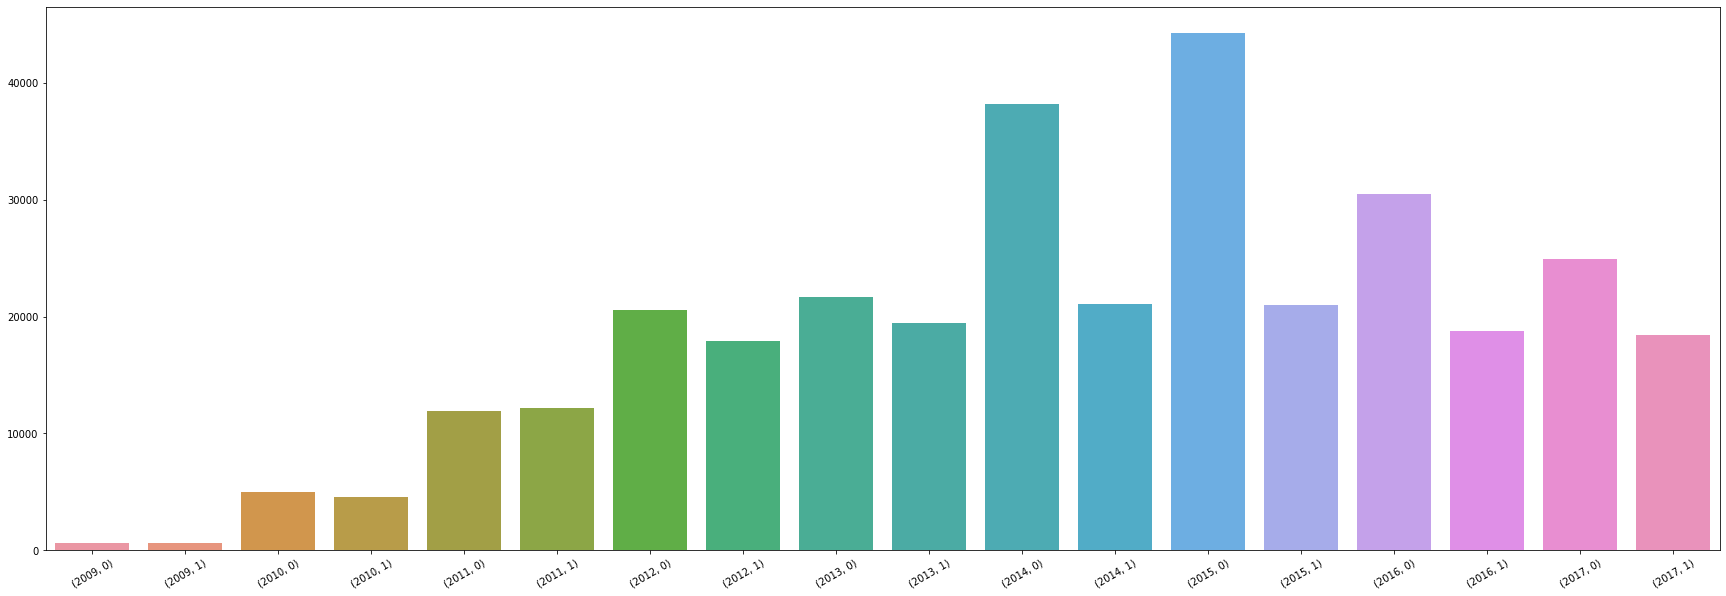

In [18]:
data_count_year = df_ks_2.groupby(["year","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_year.keys(), data_count_year.values)
g.set_xticklabels(data_count_year.keys(),rotation=30)
display(data_count_year)
df_ks_2.groupby(["year"])["state"].mean()


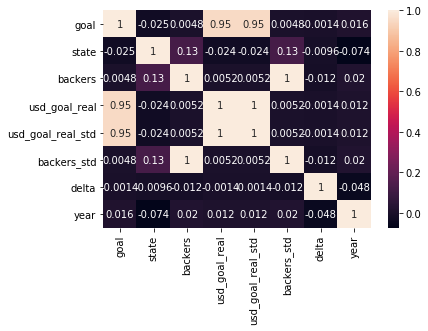

In [19]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_2.corr(), annot=True)
plt.ylim(8, 0)
plt.show()

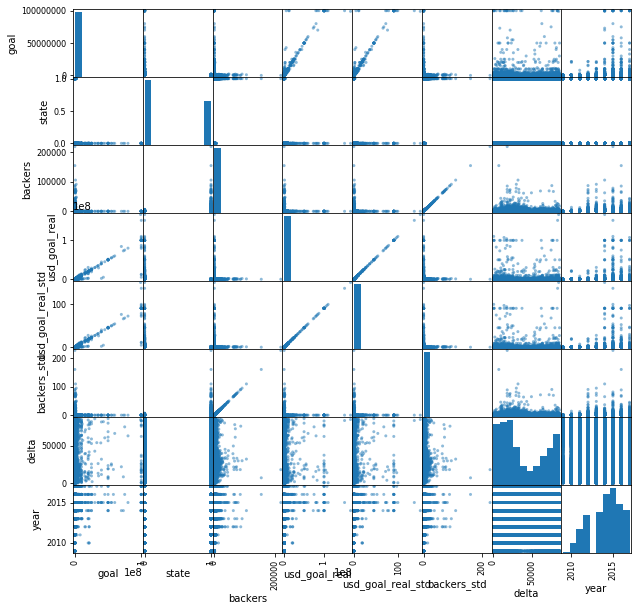

In [20]:
pd.plotting.scatter_matrix(df_ks_2, figsize=(10,10))
plt.show()

#### deltaはstateとの相関がほとんどなかった。期間が長くなるほど、成功する確率は高くなると考えたが、相関係数は負の値となっていた。プロジェクト開始年については、近年になるほど成功確率が下がっている傾向が見られる。

#### その他ではbackersが比較的stateとの相関が大きかった。, goal, usd_goalもstateと関係していると考えられる、usd_goalはgoalの通貨を揃えたものであるから、予測においては、usd_goalの方のみを用いることが妥当であると判断した。


### カテゴリーについて
#### 各カテゴリーごとの成功確率を求める。

main_category  state
Art            0        14131
               1        11510
Comics         0         4036
               1         5842
Crafts         0         5703
               1         2115
Dance          0         1235
               1         2338
Design         0        14814
               1        10550
Fashion        0        14182
               1         5593
Film & Video   0        32904
               1        23623
Food           0        15969
               1         6085
Games          0        16003
               1        12518
Journalism     0         3137
               1         1012
Music          0        21752
               1        24197
Photography    0         6384
               1         3305
Publishing     0        23145
               1        12300
Technology     0        20616
               1         6434
Theater        0         3708
               1         6534
Name: state, dtype: int64

main_category
Art             0.448890
Comics          0.591415
Crafts          0.270530
Dance           0.654352
Design          0.415944
Fashion         0.282832
Film & Video    0.417906
Food            0.275914
Games           0.438905
Journalism      0.243914
Music           0.526606
Photography     0.341108
Publishing      0.347017
Technology      0.237856
Theater         0.637961
Name: state, dtype: float64

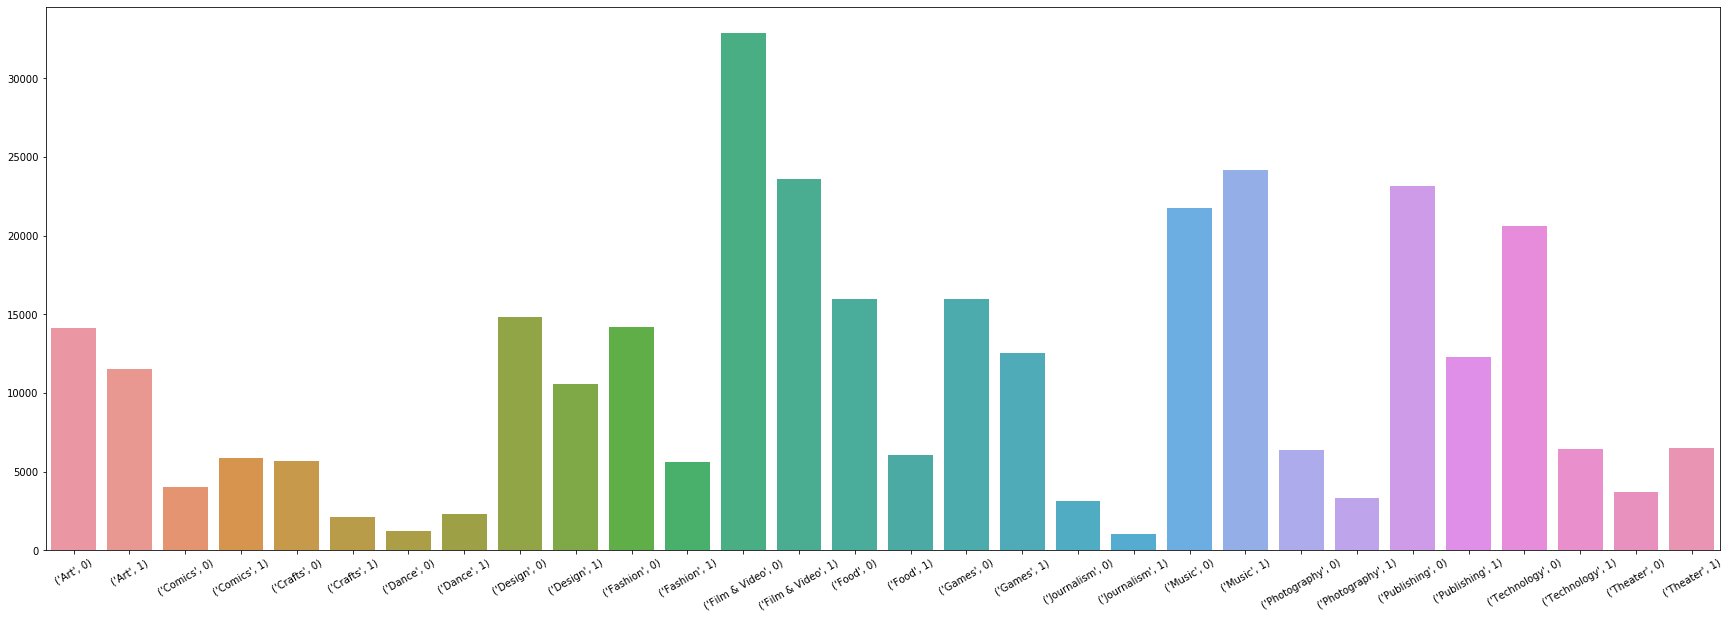

In [20]:
data_count_main_category = df_ks_2.groupby(["main_category","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_main_category.keys(), data_count_main_category.values)
g.set_xticklabels(data_count_main_category.keys(),rotation=30)
display(data_count_main_category)
df_ks_2.groupby(["main_category"])["state"].mean()


In [21]:
data_count_category = df_ks_2.groupby(["category","state"])["state"].count()
display(data_count_category)
df_ks_2.groupby(["category"])["state"].mean()

category     state
3D Printing  0         326
             1         242
Academic     0         589
             1         188
Accessories  0        1667
                      ... 
World Music  1         922
Young Adult  0         538
             1         172
Zines        0         176
             1         179
Name: state, Length: 318, dtype: int64

category
3D Printing    0.426056
Academic       0.241956
Accessories    0.391606
Action         0.172303
Animals        0.275109
                 ...   
Woodworking    0.275992
Workshops      0.337838
World Music    0.475258
Young Adult    0.242254
Zines          0.504225
Name: state, Length: 159, dtype: float64

#### カテゴリーによって成功確率は異なっているように思われる。カテゴリーの種類が多いため、予測ではメインカテゴリーのみを扱うこととする。

In [22]:
df_ks_2=pd.get_dummies(df_ks_2, columns=['main_category'])

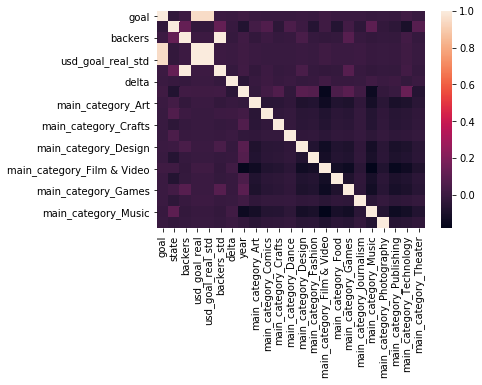

In [23]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_2.corr(), annot=False)
plt.ylim(20, 0)
plt.show()

### currency, countrryについて

currency  state
AUD       0          4610
          1          2011
CAD       0          8238
          1          4137
CHF       0           465
          1           187
DKK       0           567
          1           362
EUR       0         10496
          1          3882
GBP       0         17395
          1         12081
HKD       0           261
          1           216
JPY       0            16
          1             7
MXN       0          1015
          1           396
NOK       0           421
          1           163
NZD       0           826
          1           448
SEK       0          1001
          1           509
SGD       0           276
          1           178
USD       0        152132
          1        109379
Name: state, dtype: int64

currency
AUD    0.303731
CAD    0.334303
CHF    0.286810
DKK    0.389666
EUR    0.269996
GBP    0.409859
HKD    0.452830
JPY    0.304348
MXN    0.280652
NOK    0.279110
NZD    0.351648
SEK    0.337086
SGD    0.392070
USD    0.418258
Name: state, dtype: float64

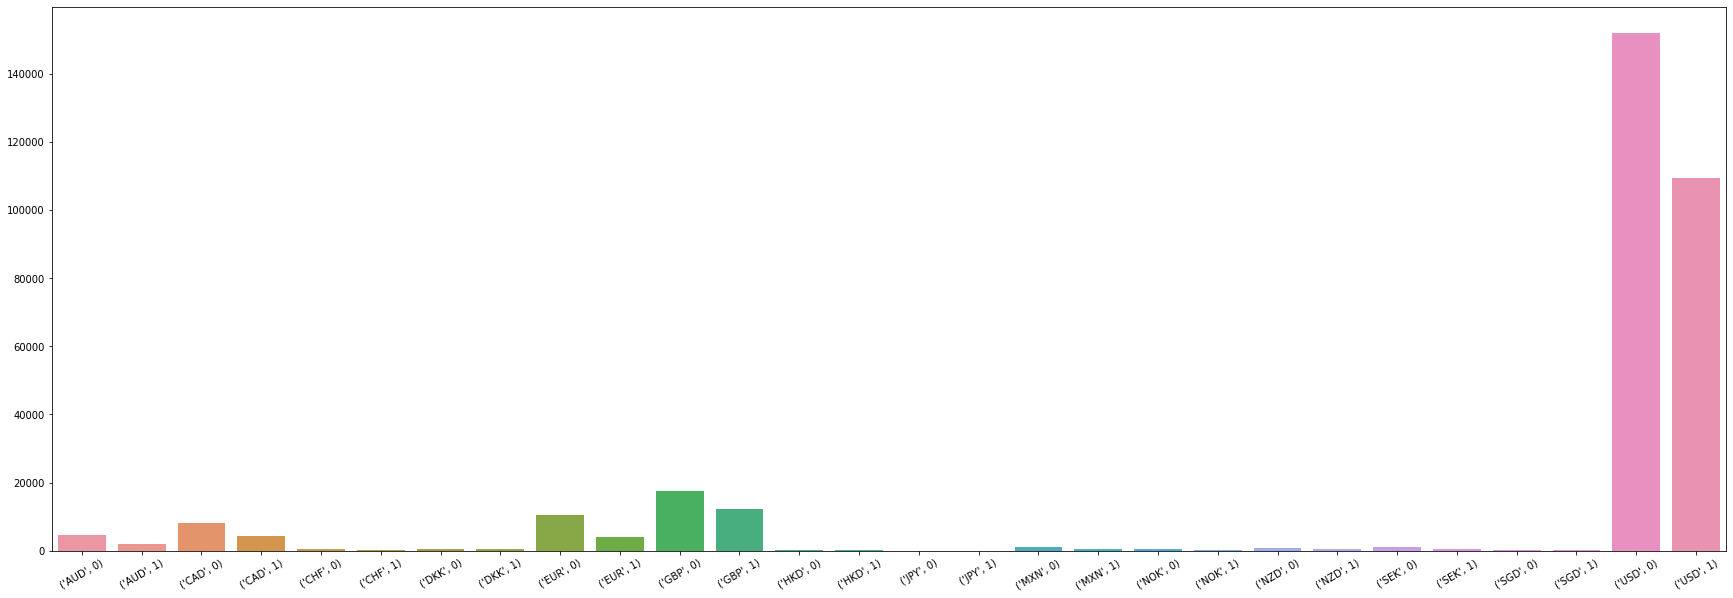

In [24]:
data_count_currency = df_ks_2.groupby(["currency","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_currency.keys(),data_count_currency.values)
g.set_xticklabels(data_count_currency.keys(),rotation=30)
display(data_count_currency)
df_ks_2.groupby(["currency"])["state"].mean()


country  state
AT       0           378
         1           107
AU       0          4606
         1          2010
BE       0           371
         1           152
CA       0          8236
         1          4134
CH       0           465
         1           187
DE       0          2499
         1           937
DK       0           566
         1           360
ES       0          1381
         1           492
FR       0          1612
         1           908
GB       0         17387
         1         12067
HK       0           261
         1           216
IE       0           476
         1           207
IT       0          1930
         1           439
JP       0            16
         1             7
LU       0            38
         1            19
MX       0          1015
         1           396
N,0"     0           105
         1           105
NL       0          1794
         1           617
NO       0           420
         1           162
NZ       0           826
         1

country
AT      0.220619
AU      0.303809
BE      0.290631
CA      0.334196
CH      0.286810
DE      0.272701
DK      0.388769
ES      0.262680
FR      0.360317
GB      0.409690
HK      0.452830
IE      0.303075
IT      0.185310
JP      0.304348
LU      0.333333
MX      0.280652
N,0"    0.500000
NL      0.255910
NO      0.278351
NZ      0.351648
SE      0.337309
SG      0.392070
US      0.418193
Name: state, dtype: float64

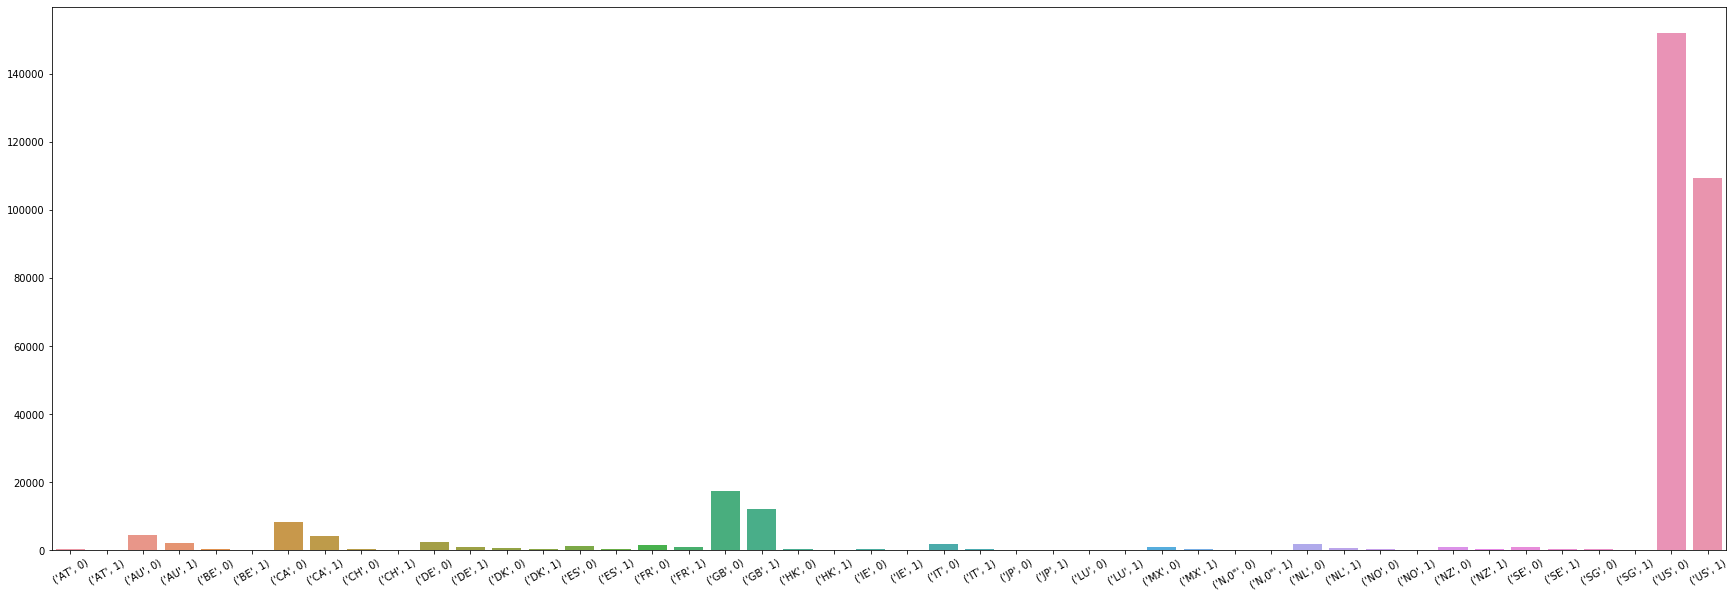

In [25]:
data_count_coutnry = df_ks_2.groupby(["country","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_coutnry.keys(), data_count_coutnry.values)
g.set_xticklabels(data_count_coutnry.keys(),rotation=30)
display(data_count_coutnry)
df_ks_2.groupby(["country"])["state"].mean()

#### 国、通貨による成功確率の違いは見られたが、データ数が少ない国が多く、信頼性が高くないと判断した。

## 予測モデルの構築

In [26]:
df_ks_2.head()

,name,category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,Monarch Espresso Bar,Restaurants,USD,2016-04-01,50000.0,2016-02-26 13:38:27,1,224,US,50000.00,...,0,0,1,0,0,0,0,0,0,0
6,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1,16,US,1000.00,...,0,0,1,0,0,0,0,0,0,0
11,Lisa Lim New CD!,Indie Rock,USD,2013-04-08,12500.0,2013-03-09 06:42:58,1,100,US,12500.00,...,0,0,0,0,0,1,0,0,0,0
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,1,761,GB,6469.73,...,0,0,0,1,0,0,0,0,0,0
18,Mike Corey's Darkness & Light Album,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,1,7,US,250.00,...,0,0,0,0,0,1,0,0,0,0


#### nameは予測に関係していないと考えられるため、今回は除外した。これまでの考察から、まずは usd_goal_std, backers_std, main_categoryのダミー変数, yearで予測を行うこととした。

In [27]:
X = df_ks_2.drop(["state", "launched", "country", "usd_goal_real", "backers", "name", "category", "currency", "deadline", "goal", "delta"], axis=1)
y = df_ks_2["state"]
X.head()

,usd_goal_real_std,backers_std,year,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,0.007656,0.111472,2016,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,-0.036531,-0.103976,2014,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11,-0.026160,-0.016968,2013,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14,-0.031598,0.667704,2017,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18,-0.037207,-0.113299,2012,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### ロジスティック回帰で予測

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 

In [29]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w = clf.coef_

print(w0)
print(w)

2.8646894724085463
[[-7.00409826e+02  5.02826387e+03  1.81865909e-01  2.32669049e+02
   3.49492572e+02 -1.89691331e+02  3.05202146e+02  5.39141413e+00
  -3.34609056e+02  1.65635953e+02 -4.02694405e+02  1.41308451e+01
  -1.25724983e+02  2.31231170e+02  5.02493530e+00  4.33451138e+01
  -8.91915126e+02  5.95376393e+02]]


#### 結果の表示

In [30]:
# ラベルを予測
y_est = clf.predict(X)

# 確率値を得る
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -2462083.130
正答率 = 75.394%
適合率（Precision） = 65.064%
再現率（Recall） = 84.386%
F1値（F1-score） = 73.476%


In [31]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

conf_mat

,予測 = failed,予測 = successful
正解 = failed,137022,60697
正解 = successful,20916,113040


#### 予測モデルの構築が完了した。テストデータに対して、適合率は高いが、再現率は低いという結果であった。他の説明変数の組み合わせも試す。

In [32]:
X2 = df_ks_2[["usd_goal_real_std", "backers_std"]]
y = df_ks_2["state"]
X2.head()

,usd_goal_real_std,backers_std
5,0.007656,0.111472
6,-0.036531,-0.103976
11,-0.026160,-0.016968
14,-0.031598,0.667704
18,-0.037207,-0.113299


In [33]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X2, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w = clf.coef_

print(w0)
print(w)

# ラベルを予測
y_est = clf.predict(X2)

# 確率値を得る
y_est_proba = clf.predict_proba(X2)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

conf_mat

-0.45152865536592185
[[-91.55555349  32.98273605]]
対数尤度 = -120617.571
正答率 = 85.924%
適合率（Precision） = 91.578%
再現率（Recall） = 71.747%
F1値（F1-score） = 80.459%


,予測 = failed,予測 = successful
正解 = failed,188880,8839
正解 = successful,37846,96110


#### usd_goal_std backers_stdのみを用いた方がテストデータに対する精度は高いように思われる。他のモデルでも検証していきたい。
#### usd_goal_std backers_stdのみを用いたモデルについて、予測値の境界線を図示する。

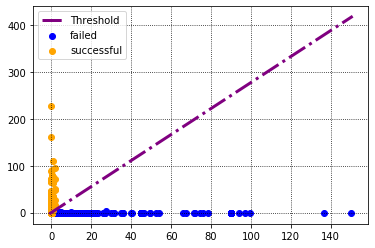

In [34]:
# データをプロット
df_success_2 = df_ks_2[df_ks_2['state']==1]
df_fail_2 = df_ks_2[df_ks_2['state']==0]

plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.scatter(df_fail_2['usd_goal_real_std'], df_fail_2['backers_std'], color='b', label='failed')
plt.scatter(df_success_2['usd_goal_real_std'], df_success_2['backers_std'], color='orange', label='successful')

# 境界線をプロットして表示
x = df_ks_2['usd_goal_real_std']
line_x = np.arange(np.min(x) - 1, np.max(x) + 1)
line_y = - line_x * w[0, 0] / w[0, 1] - w0 / w[0, 1]
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.legend(loc='best')
plt.show()


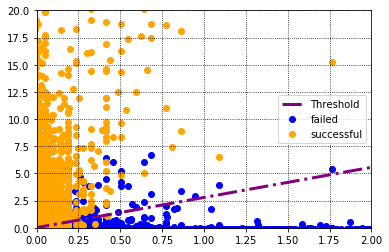

In [35]:
# データをプロット
df_success_2 = df_ks_2[df_ks_2['state']==1]
df_fail_2 = df_ks_2[df_ks_2['state']==0]

plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.scatter(df_fail_2['usd_goal_real_std'], df_fail_2['backers_std'], color='b', label='failed')
plt.scatter(df_success_2['usd_goal_real_std'], df_success_2['backers_std'], color='orange', label='successful')

# 境界線をプロットして表示
x = df_ks_2['usd_goal_real_std']
line_x = np.arange(np.min(x) - 1, np.max(x) + 1)
line_y = - line_x * w[0, 0] / w[0, 1] - w0 / w[0, 1]
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.xlim([0,2])
plt.ylim([0,20])
plt.legend(loc='best')
plt.show()


#### usd_goal_std backers_stdのみを用いた予測モデルは、両者の値が小さい部分で当てはまりが悪くなっており、改善の余地がある。
#### usd_goal_std backers_stdにmain_categoryのみを加えた場合にどうなるかも検証した。

In [36]:
X3 = df_ks_2.drop(["state", "launched", "country", "usd_goal_real", "backers", "name", "category", "currency", "deadline", "goal", "delta", "year"], axis=1)
X.head()

,usd_goal_real_std,backers_std,year,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,0.007656,0.111472,2016,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,-0.036531,-0.103976,2014,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11,-0.026160,-0.016968,2013,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14,-0.031598,0.667704,2017,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18,-0.037207,-0.113299,2012,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [37]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X3, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w = clf.coef_

print(w0)
print(w)

# ラベルを予測
y_est = clf.predict(X3)

# 確率値を得る
y_est_proba = clf.predict_proba(X3)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

conf_mat

-0.3189897637710689
[[-8.53106763e+01  3.32350429e+01  4.31030357e-01  1.12291838e-01
  -2.87361592e-01  1.12353032e+00 -5.73212581e-01 -3.48821350e-01
   3.20799454e-01 -3.86668616e-01 -9.69848541e-01 -3.72033307e-01
   5.00578257e-01 -4.44479314e-02 -1.65921905e-01 -7.22506350e-01
   1.06360218e+00]]
対数尤度 = -116044.150
正答率 = 87.255%
適合率（Precision） = 91.733%
再現率（Recall） = 75.222%
F1値（F1-score） = 82.661%


,予測 = failed,予測 = successful
正解 = failed,188638,9081
正解 = successful,33191,100765


#### 説明変数の追加により、精度の向上したモデルが得られた。yearについては説明変数に含めると精度が悪くなってしまうため、説明変数として不適切か、使用方法が悪い可能性がある。またモデルが過学習しているかどうかも現状では不明である。